# target encoder & ohe & DeepFM - basic

In [1]:
%load_ext autoreload
%autoreload 2

import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath('..'))
# ---------------------------------
from time import sleep
import numpy as np
import pandas as pd
import scipy
import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score

from hyperopt import hp
# ---------------------------------
from tools import CV, Tuning, CVGetScore, IdxValEncoder, linear_regression, CyclicLR, MaxLrFinder
# ---------------------------------
from tools import focal_loss, gelu, mish
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({'focal_loss': focal_loss()})
get_custom_objects().update({'mish': mish})
get_custom_objects().update({'gelu': gelu})

In [2]:
train_df = pd.read_csv('../data/train.csv', index_col='id')
test_df = pd.read_csv('../data/test.csv', index_col='id')

# ord_5
for i in range(2):
    train_df[f'ord_5_{i}'] = train_df['ord_5'].str[i]
    test_df[f'ord_5_{i}'] = test_df['ord_5'].str[i]

# null
train_df['null'] = train_df.isna().sum(axis=1)
test_df['null'] = test_df.isna().sum(axis=1)

for col in test_df.columns:
    train_df[col].fillna('isnull', inplace=True)
    test_df[col].fillna('isnull', inplace=True)

# target
target = train_df['target']
y_train = target.values

# drop
train_df.drop(['target', 'ord_5'], axis=1, inplace=True)
test_df.drop(['ord_5'], axis=1, inplace=True)

In [3]:
feature_col = train_df.columns

bin_col = ['null']

class_col = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
             'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
             'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9',
             'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
             'day', 'month', 'ord_5_0', 'ord_5_1']

In [4]:
# for col in bin_col:
#     map_dict = dict(zip(train_df[col].unique(), [0., 1.]))
#     train_df[col] = train_df[col].map(map_dict)
#     test_df[col] = test_df[col].map(map_dict)

In [5]:
ecd = IdxValEncoder(feature_col, bin_col=bin_col, class_col=class_col)
ecd.fit(train_df, verbose=1)

600000it [00:10, 54651.14it/s]


In [6]:
ecd.fit(test_df, verbose=1)

400000it [00:07, 52272.10it/s]


In [7]:
idx, val = ecd.transform(train_df, verbose=1)
idx_test, val_test = ecd.transform(test_df, verbose=1)

600000it [00:12, 47009.50it/s]
400000it [00:10, 38327.04it/s]


# Search Max LR

In [22]:
%%time

batch_size = 8192
epochs = 10
nflold = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'mse'}

mf = MaxLrFinder(1e-7, 1e-0, epochs=epochs, batch_size=batch_size, sample_length=train_df.shape[0]*((nflold-1)/nflold))
fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[mf]}

model = linear_regression(**model_param)

cv = CV(model, nflold)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/10
480000/480000 [==============================] - 2s 5us/sample - loss: 0.2648 - AUC: 0.4974 - val_loss: 0.2647 - val_AUC: 0.4985
Epoch 2/10
480000/480000 [==============================] - 1s 2us/sample - loss: 0.2646 - AUC: 0.4973 - val_loss: 0.2644 - val_AUC: 0.4984
Epoch 3/10
480000/480000 [==============================] - 1s 2us/sample - loss: 0.2639 - AUC: 0.4974 - val_loss: 0.2628 - val_AUC: 0.4986
Epoch 4/10
480000/480000 [==============================] - 1s 2us/sample - loss: 0.2601 - AUC: 0.4977 - val_loss: 0.2552 - val_AUC: 0.4986
Epoch 5/10
480000/480000 [==============================] - 1s 2us/sample - loss: 0.2430 - AUC: 0.4985 - val_loss: 0.2231 - val_AUC: 0.5002
Epoch 6/10
480000/480000 [==============================] - 1s 2us/sample - loss: 0.1923 - AUC: 0.5021 - val_loss: 0.1623 - val_AUC: 0.5219
Epoch 7/10
480000/480000 [==============================] - 1s 2us/sample - loss: 0.1528 - AUC: 0.5553 - val

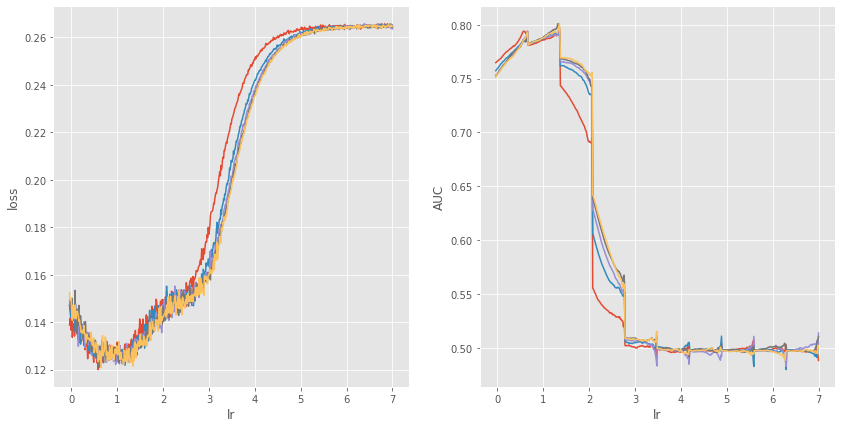

In [23]:
%matplotlib inline
mf.plot(True)

# fit one

In [20]:
%%time

batch_size = 8192
epochs = 100
nflod = 5

model_param = {'vocabulary_size':ecd.get_vocabulary(), 
               'feature_number': len(feature_col),
               'activation': 'sigmoid',
               'metrics': ['AUC'],
               'optimizer': 'Adam',
               'loss': 'binary_crossentropy'}

clr = CyclicLR(base_lr=1e-3,
               max_lr = 1e-2, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', patience=3, mode='max', restore_best_weights=True)

fit_param = {'batch_size': batch_size, 'epochs':epochs, 'verbose': 1, 'callbacks':[es, clr]}

model = linear_regression(**model_param)

cv = CV(model, nflod)

score = cv.fit(x=[idx, val],
               y=y_train, 
               metrics_func=roc_auc_score,
               split_method=StratifiedKFold,
               fit_params=fit_param,
               eval_param={'batch_size':batch_size},
               use_proba=False, 
               verbose=True,
               fit_use_valid=True)

tf.keras.backend.clear_session()

Train on 480000 samples, validate on 120000 samples
Epoch 1/100
480000/480000 [==============================] - 2s 5us/sample - loss: 0.5422 - AUC: 0.5133 - val_loss: 0.4740 - val_AUC: 0.6333
Epoch 2/100
480000/480000 [==============================] - 1s 2us/sample - loss: 0.4575 - AUC: 0.7244 - val_loss: 0.4412 - val_AUC: 0.7698
Epoch 3/100
480000/480000 [==============================] - 1s 2us/sample - loss: 0.4250 - AUC: 0.7829 - val_loss: 0.4146 - val_AUC: 0.7823
Epoch 4/100
480000/480000 [==============================] - 1s 2us/sample - loss: 0.4038 - AUC: 0.7917 - val_loss: 0.4019 - val_AUC: 0.7855
Epoch 5/100
480000/480000 [==============================] - 1s 2us/sample - loss: 0.3944 - AUC: 0.7955 - val_loss: 0.3981 - val_AUC: 0.7868
Epoch 6/100
480000/480000 [==============================] - 1s 2us/sample - loss: 0.3910 - AUC: 0.7977 - val_loss: 0.3972 - val_AUC: 0.7870
Epoch 7/100
480000/480000 [==============================] - 1s 2us/sample - loss: 0.3895 - AUC: 0.799

In [21]:
score

0.7874854140397407

# Tuning

In [28]:
%matplotlib qt5

batch_size = 8192
epochs = 100
nflod = 5

# fit param

clr = CyclicLR(base_lr=1e-3,
               max_lr = 1e-2, 
               step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
               mode='triangular2',
               gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

cv_fit_param = {'fit_params': fit_param, 
                'eval_param': {'batch_size':batch_size},
                'use_proba':False, 
                'fit_use_valid': True}

# model_fix_param & model_search_space
model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam'}

ss = {
    'loss': (hp.choice, ('MSE', 'binary_crossentropy', 'focal_loss')), 
    'l1': (hp.loguniform, (-30, -10)),
    'l2': (hp.loguniform, (-30, -10))}

# cv get score
def neg_auc(y_true, y_pred):
    return - roc_auc_score(y_true, y_pred)

gs = CVGetScore(x=[idx, val],
                y=y_train, 
                metrics_func=neg_auc,
                split_method=StratifiedKFold,
                nfolds=nflod, 
                random_state=2333,
                model=linear_regression, 
                cv_fit_params=cv_fit_param, 
                model_fix_params=model_fix_param, 
                model_search_space=ss)

tuning = Tuning(gs, verbose=1)
tuning.fmin(gs.GET_SEARCH_SPACE(), max_evals=100)

new best, eval 1, score -0.7867, param {'l1': 5.331170590764536e-11, 'l2': 1.8455625603579383e-11, 'loss': 'focal_loss'}
new best, eval 2, score -0.7871, param {'l1': 1.677110306621574e-13, 'l2': 1.794394614026637e-06, 'loss': 'MSE'}
new best, eval 5, score -0.7878, param {'l1': 2.6207048761931395e-11, 'l2': 9.014904672394258e-12, 'loss': 'binary_crossentropy'}
new best, eval 10, score -0.7879, param {'l1': 7.085966756719543e-11, 'l2': 1.3930624539666502e-06, 'loss': 'binary_crossentropy'}
new best, eval 14, score -0.788, param {'l1': 3.7894629492134646e-06, 'l2': 4.2277419795185174e-07, 'loss': 'binary_crossentropy'}
new best, eval 22, score -0.7881, param {'l1': 1.2792167965355976e-13, 'l2': 1.0223241816747619e-05, 'loss': 'binary_crossentropy'}
new best, eval 38, score -0.7881, param {'l1': 1.1655928512397352e-13, 'l2': 1.6492056269159343e-05, 'loss': 'binary_crossentropy'}
100%|██████████| 100/100 [3:02:22<00:00, 109.43s/trial, best loss: -0.7880841009224967] 


{'l1': 1.1655928512397352e-13, 'l2': 1.6492056269159343e-05, 'loss': 1}

In [33]:
log = tuning.log.get_log()

In [34]:
log.sort_values('score').head(20)

,score,update,usetime,l1,l2,loss
37,-0.788084,True,143.208486,1.165593e-13,1.649206e-05,binary_crossentropy
85,-0.788066,False,169.677870,1.353164e-11,2.078607e-05,binary_crossentropy
21,-0.788060,True,126.226224,1.279217e-13,1.022324e-05,binary_crossentropy
92,-0.788055,False,78.638746,2.412837e-13,9.091153e-06,focal_loss
13,-0.788048,True,124.593422,3.789463e-06,4.227742e-07,binary_crossentropy
30,-0.788042,False,128.301105,4.099085e-06,4.869798e-07,binary_crossentropy
87,-0.788041,False,144.196029,7.040804e-13,1.884672e-05,binary_crossentropy
75,-0.788041,False,76.915167,1.058368e-09,1.182052e-05,focal_loss
65,-0.788037,False,121.586816,3.248638e-06,4.923409e-07,binary_crossentropy
38,-0.788034,False,89.357681,1.182731e-13,1.429444e-05,focal_loss


In [35]:
log.sort_values('score').tail(20)

,score,update,usetime,l1,l2,loss
76,-0.786969,False,101.651458,1.418065e-13,1.519133e-07,MSE
40,-0.786955,False,101.025884,3.116385e-12,5.918796e-08,MSE
51,-0.786949,False,103.580635,7.054745e-11,5.807739e-11,MSE
99,-0.786946,False,137.093548,1.564785e-13,1.440045e-05,MSE
7,-0.786936,False,75.056449,2.860090e-09,1.073824e-13,focal_loss
48,-0.786932,False,104.759216,1.670892e-11,1.077751e-12,MSE
3,-0.786931,False,102.346211,3.561273e-12,1.953642e-08,MSE
93,-0.786931,False,102.269417,2.359805e-12,9.321642e-12,MSE
15,-0.786916,False,107.188767,2.772595e-11,1.668604e-11,MSE
0,-0.786668,True,38.214141,5.331171e-11,1.845563e-11,focal_loss


[-0.789, -0.787]
[-0.789, -0.787]
[-0.789, -0.787]


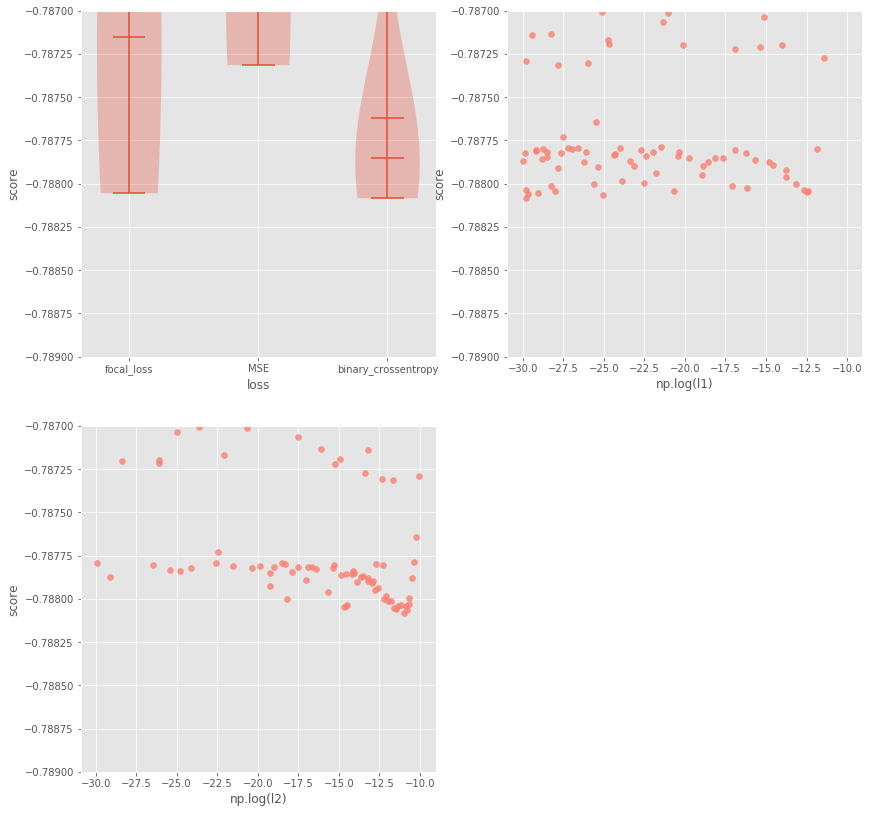

In [37]:
%matplotlib inline
tuning.log.plot(score_interval=[-0.789, -0.787])

### 2432137157

In [39]:
log.to_csv('../tmp/lr/2432137157.csv', index=False)

In [40]:
batch_size = 8192
epochs = 400
nflod = 40
nmodel = 5

In [41]:
# model params
model_tuning_param = log.sort_values('score').head(nmodel).reset_index(drop=True).to_dict()

model_fix_param = {'vocabulary_size':ecd.get_vocabulary(), 
                   'feature_number': len(feature_col),
                   'activation': 'sigmoid',
                   'metrics': ['AUC'],
                   'optimizer': 'Adam'}

In [42]:
# callbacks
clr = CyclicLR(
    base_lr=1e-4,
    max_lr = 1e-2, 
    step_size= int(4.0*(train_df.shape[0]*((nflod-1)/nflod)) / batch_size),
    mode='triangular2',
    gamma=1.0)

es = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', 
                                      patience=3,
                                      mode='max',
                                      restore_best_weights=True)

# fit
fit_param = {
    'batch_size': batch_size, 
    'epochs':epochs, 
    'verbose': 0,
    'callbacks':[es, clr]
}

# Stacking 1

In [43]:
pred_lst = []
score_lst = []
pred_arr_lst = []

for i in range(nmodel):
    model_params = {}
    for param_name, param_value in model_fix_param.items():
        model_params[param_name] = param_value
        
    for param_name in model_tuning_param.keys():
        if param_name not in ['score', 'update', 'usetime', 'index']:
            model_params[param_name] = model_tuning_param[param_name][i]
            
    # cv
    model = linear_regression(**model_params)
    cv = CV(model, nflod)
    
    score, pred_arr = cv.fit(x=[idx, val],
                             y=y_train, 
                             metrics_func=roc_auc_score,
                             split_method=StratifiedKFold,
                             fit_params=fit_param,
                             eval_param={'batch_size':batch_size},
                             use_proba=False, 
                             verbose=True,
                             fit_use_valid=True,
                             output_oof_pred=True)
    
    pred = cv.predict(x=[idx_test, val_test], pred_param={'batch_size': batch_size})
    
    pred_lst.append(pred)
    score_lst.append(score)
    pred_arr_lst.append(pred_arr)
    
    print('score: ', score)
    tf.keras.backend.clear_session()

folds 0 is done, score is 0.7809012355026135
folds 1 is done, score is 0.7874371961016892
folds 2 is done, score is 0.788195788093262
folds 3 is done, score is 0.7855519691816034
folds 4 is done, score is 0.7897592549362151
folds 5 is done, score is 0.7891178378844471
folds 6 is done, score is 0.7885945889042182
folds 7 is done, score is 0.7871133621318169
folds 8 is done, score is 0.7878389032834571
folds 9 is done, score is 0.7818599289338298
folds 10 is done, score is 0.7860292127947148
folds 11 is done, score is 0.7983597757578647
folds 12 is done, score is 0.7854386791394665
folds 13 is done, score is 0.7885119691068265
folds 14 is done, score is 0.7849967501224473
folds 15 is done, score is 0.7872269588764012
folds 16 is done, score is 0.7880633656603555
folds 17 is done, score is 0.7907003933035346
folds 18 is done, score is 0.7919526740013535
folds 19 is done, score is 0.7937828843443181
folds 20 is done, score is 0.7875550720756592
folds 21 is done, score is 0.7854453973835537

folds 18 is done, score is 0.7918500309156068
folds 19 is done, score is 0.7924880596355743
folds 20 is done, score is 0.7863631971551099
folds 21 is done, score is 0.7845066980309352
folds 22 is done, score is 0.785488510984738
folds 23 is done, score is 0.7818683705535739
folds 24 is done, score is 0.7815726363698394
folds 25 is done, score is 0.7859685149198765
folds 26 is done, score is 0.7912993247638918
folds 27 is done, score is 0.7791177461658104
folds 28 is done, score is 0.7951578752308739
folds 29 is done, score is 0.7851068416962036
folds 30 is done, score is 0.7886826855310287
folds 31 is done, score is 0.7866884916128273
folds 32 is done, score is 0.785317312599547
folds 33 is done, score is 0.7891597977002341
folds 34 is done, score is 0.7918447001349725
folds 35 is done, score is 0.7915914807524059
folds 36 is done, score is 0.7833390233939774
folds 37 is done, score is 0.7821138179806234
folds 38 is done, score is 0.7896268451018394
folds 39 is done, score is 0.7809711

In [44]:
pred_arr = np.array(pred_arr_lst).squeeze().T
np.save('../tmp/lr/2432137157stacking1.npy', pred_arr)
pred_arr.shape

(600000, 5)

In [45]:
pred = np.array(pred_lst).squeeze().T
np.save('../tmp/lr/2432137157predict.npy', pred)
pred.shape

(400000, 5)

In [46]:
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')
submission['target'] = np.mean(pred_lst, axis=0)
submission.to_csv('../tmp/submission/main_1_lr_2432137157.csv')